# Homework08

Exercises to practice pandas, data analysis and classification

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build intuition for different classification models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [18]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/PSAM-5020-2025F-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [19]:
import pandas as pd
import PIL.Image as PImage

from os import listdir, path

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from data_utils import classification_error, display_confusion_matrix, regression_error

from image_utils import get_pixels, make_image

from Homework08_utils import CamUtils

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

Alternatively, we could try using a `OneHotEncoder`, but since we have $25$ cameras, adding $25$ sparse columns to our dataset might confuse our classification fitting.

In [20]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [21]:
# TODO: check and see what is inside the list here
print(train_files[:10])


['06-37.jpg', '13-47.jpg', '07-42.jpg', '21-60.jpg', '01-46.jpg', '01-19.jpg', '01-30.jpg', '25-83.jpg', '02-47.jpg', '03-67.jpg']


Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [22]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = PImage.open(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [23]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print(train_files[:5])
print(label_data[:5])

['06-37.jpg', '13-47.jpg', '07-42.jpg', '21-60.jpg', '01-46.jpg']
[4, 11, 5, 16, 0]


The labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly (they're squares, so no need to specify `width`):

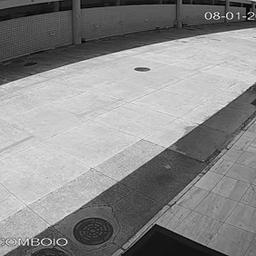

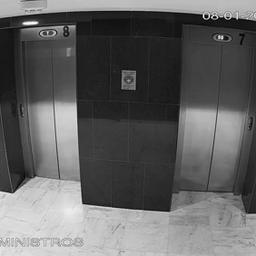

In [24]:
display(make_image(pixel_data[0]))
display(make_image(pixel_data[10]))

And now might not be a bad time to peek into the `data/image/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [25]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [26]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,77,77,78,79,82,85,88,90,94,95,...,107,94,106,113,110,109,114,112,106,4
1,84,90,99,102,99,97,102,109,99,106,...,193,200,204,209,213,216,218,221,223,11
2,57,57,56,54,53,55,60,64,58,57,...,162,155,159,164,165,164,162,163,165,5
3,100,101,102,103,103,103,103,102,102,102,...,157,151,152,153,154,154,154,153,153,16
4,90,94,97,99,97,94,92,92,94,94,...,138,127,187,238,239,214,194,175,158,0


### Insight

<span style="color:hotpink">
Does anything stand out as peculiar about the feature values in our <code>DataFrame</code>?<br>
Do we have to encode or scale our data?<br>
Why? Or, why not?<br>
</span>

<span style="color:hotpink;">The pixel values are already numbers between 0 and 255, so there’s nothing strange about them. Each column just represents one pixel from an image. We don’t need to encode anything since there are no text labels, and we don’t need to scale the data because all features (pixels) share the same range. The data is ready to be used for training.
</span>

### Test Files

If that worked, repeat the process for the test files inside the `./data/image/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

In [27]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/image/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
print(len(test_files))
print(test_files[:10])

# TODO: loop over files and load their pixels into a list
test_pixel_data = []
for fname in test_files:
    img = PImage.open(path.join("./data/image/0801-500/test", fname))
    test_pixel_data.append(get_pixels(img))

# TODO: load into DataFrame (this might take 20 - 30 seconds)
test_df = pd.DataFrame(test_pixel_data)



1573
['13489403.jpg', '6026399.jpg', '13613769.jpg', '13590281.jpg', '15358872.jpg', '15773605.jpg', '16072048.jpg', '5588373.jpg', '7624572.jpg', '8804586.jpg']


Check the `DataFrame`

In [28]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,52,53,53,53,54,58,63,67,62,62,...,170,166,161,163,167,170,173,174,173,172
1,65,64,63,62,61,61,61,61,63,62,...,91,90,81,91,89,82,82,80,80,90
2,170,183,189,202,235,253,244,231,247,241,...,86,95,102,113,126,134,135,130,126,124
3,123,123,123,123,123,123,123,123,124,124,...,158,156,155,152,145,140,143,148,147,142
4,53,56,57,56,54,56,63,70,57,57,...,167,160,158,159,161,164,166,166,166,166


Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [29]:
# split input and output features
NUM_FEATURES = 10
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

Experiment with more pixels (more features)

In [30]:
NUM_FEATURES = 50  # or 100
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]
test_features = test_df[chosen_columns]

# Re-run RandomForest
model = RandomForestClassifier()
model.fit(train_features, out_features)
train_predictions = model.predict(train_features)
print("RandomForest train accuracy (50 features):", CamUtils.classification_accuracy(train_files, train_predictions))

test_predictions = model.predict(test_features)
print("RandomForest test accuracy (50 features):", CamUtils.classification_accuracy(test_files, test_predictions))


RandomForest train accuracy (50 features): 1.0
RandomForest test accuracy (50 features): 0.7800381436745073


From our [Week 08](https://github.com/PSAM-5020-2025F-A/WK08) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error*
7. Run model on test data, measure error*, plot predictions, interpret results

We could use the same `regression_error()` function we used previously to measure the error of our classifier model, but this could lead to $2$ issues. First, we don't have labels for the images in the test dataset, and second, the regression error reported might be higher than it actually is because an image with label $0$ that gets mislabeled as $5$ will count as being more wrong than if it was mislabeled $2$. And we don't want that. We just want to get the percentage of classifications that our model gets correctly.

To simplify calculating the classification accuracy we can use the `CamUtils.classification_accuracy()` function. This function takes $2$ parameters, a list of files and a list of predictions. It will work with the test and train datasets and will calculate a more meaningful accuracy value than the one returned by `regression_error()`.

In [31]:
# TODO: create a brand new classifier
model = RandomForestClassifier()

# TODO: fit the model
model.fit(train_features, out_features)

# TODO: run predictions
train_predictions = model.predict(train_features)

# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, train_predictions)


1.0

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [32]:
# TODO: run predictions on test data
test_predictions = model.predict(test_features)

# TODO: measure classification accuracy
CamUtils.classification_accuracy(test_files, test_predictions)


0.7774952320406866

Experiment with SVC

In [33]:
from sklearn.svm import SVC

# Create SVC model
svc_model = SVC()

# Fit the model on training features
svc_model.fit(train_features, out_features)

# Predictions on training data
svc_train_predictions = svc_model.predict(train_features)
print("SVC train accuracy:", CamUtils.classification_accuracy(train_files, svc_train_predictions))

# Predictions on test data
svc_test_predictions = svc_model.predict(test_features)
print("SVC test accuracy:", CamUtils.classification_accuracy(test_files, svc_test_predictions))


SVC train accuracy: 0.58
SVC test accuracy: 0.5244755244755245


### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data?<br>
How does the choice of pixels affect the accuracy?<br><br>
If you're curious, repeat the modeling above, but using the <code>SVC</code> classifier instead of <code>RandomForest</code>.<br>How does the choice of modeling technique affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

<span style="color:hotpink;">
Using only the first few pixels means the model doesn’t have enough information to tell the images apart very well. If we use more pixels, the model can see more details and usually becomes more accurate, but it also takes longer to train.

The choice of which pixels we use matters too. Pixels that capture clear parts of the image (like edges or patterns) help the model do better than random ones.

While trying an SVC model instead of RandomForest, the results can change. SVC might do better when the data is simple and clear, while RandomForest works better with more complex or noisy data. Overall, using more useful pixels and the right model helps improve the accuracy.
</span>

Experiment with different pixels (not just the first N)

In [34]:


# using a different block of 50 pixels instead of the first 50
NUM_FEATURES = 50
chosen_columns = train_df.columns[100:150]  # pick pixels from column 100 to 149

# Prepare training and test features
train_features_diff_pixels = train_df[chosen_columns]
test_features_diff_pixels = test_df[chosen_columns]

# RandomForest with different pixels

from sklearn.ensemble import RandomForestClassifier

# Create RandomForest model
rf_diff_pixels = RandomForestClassifier()

# Fit the model on the new features
rf_diff_pixels.fit(train_features_diff_pixels, out_features)

# Predict on training data
rf_train_predictions_diff = rf_diff_pixels.predict(train_features_diff_pixels)
print("RandomForest train accuracy (different pixels):", 
      CamUtils.classification_accuracy(train_files, rf_train_predictions_diff))

# Predict on test data
rf_test_predictions_diff = rf_diff_pixels.predict(test_features_diff_pixels)
print("RandomForest test accuracy (different pixels):", 
      CamUtils.classification_accuracy(test_files, rf_test_predictions_diff))

# SVC with different pixels

from sklearn.svm import SVC

# Create SVC model
svc_diff_pixels = SVC()

# Fit the model
svc_diff_pixels.fit(train_features_diff_pixels, out_features)

# Predict on training data
svc_train_predictions_diff = svc_diff_pixels.predict(train_features_diff_pixels)
print("SVC train accuracy (different pixels):", 
      CamUtils.classification_accuracy(train_files, svc_train_predictions_diff))

# Predict on test data
svc_test_predictions_diff = svc_diff_pixels.predict(test_features_diff_pixels)
print("SVC test accuracy (different pixels):", 
      CamUtils.classification_accuracy(test_files, svc_test_predictions_diff))



RandomForest train accuracy (different pixels): 1.0
RandomForest test accuracy (different pixels): 0.8003814367450731
SVC train accuracy (different pixels): 0.564
SVC test accuracy (different pixels): 0.5143038779402416


Observation

Changing which pixels we use affects how well the model works. RandomForest got perfect accuracy on the training data (1.0) but only about 0.80 on the test data, which means it memorized the training images but didn’t generalize perfectly. SVC did much worse (aprox 0.56 train, 0.51 test), showing it couldn’t learn well from these pixels. This shows that choosing the right pixels matters, pixels that capture important parts of the image help the model perform better.